In [1]:
pip install onnxruntime opencv-python numpy


Note: you may need to restart the kernel to use updated packages.


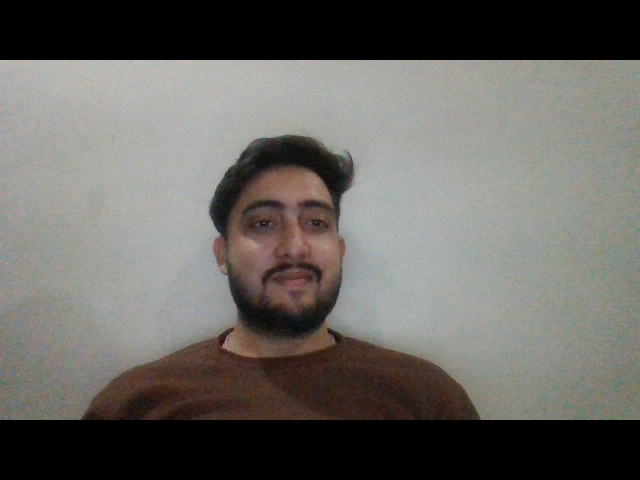

Stream stopped.


error: OpenCV(4.1.2) C:\projects\opencv-python\opencv\modules\highgui\src\window.cpp:645: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


In [4]:
import onnxruntime as ort
import cv2
import numpy as np
from IPython.display import display, clear_output
from PIL import Image

# Path to your ONNX model
onnx_model_path = r"C:\yolo elephant detection\Elephant Detection\best.onnx"

# Load the ONNX model
session = ort.InferenceSession(onnx_model_path)

# Initialize the camera (use 0 for default camera)
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open the camera.")
    cap.release()
    exit()

print("Press 'Stop' in Jupyter Notebook to stop the video stream.")

try:
    while True:
        # Capture a frame from the camera
        ret, frame = cap.read()
        if not ret:
            print("Error: Failed to grab a frame.")
            break

        # Preprocess the frame
        img = cv2.resize(frame, (640, 640))  # Resize to match model input size
        img = img.transpose(2, 0, 1)  # Change to channels-first format
        img = np.expand_dims(img, axis=0).astype(np.float32) / 255.0  # Normalize and add batch dimension

        # Run inference
        inputs = {session.get_inputs()[0].name: img}
        outputs = session.run(None, inputs)

        # Process outputs (Assume YOLO-like output: bounding boxes, confidence, class labels)
        detections = outputs[0]  # Adjust based on your model's output format

        for detection in detections[0]:  # Iterate through detections
            x1, y1, x2, y2 = detection[:4]
            confidence = detection[4]
            label = int(detection[5])

            # Draw bounding box and label on the frame
            if confidence > 0.5:  # Only consider detections with confidence > 0.5
                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                cv2.putText(frame, f"Class {label}: {confidence:.2f}", (int(x1), int(y1) - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Convert BGR (OpenCV format) to RGB for Jupyter display
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Display the frame in Jupyter Notebook
        clear_output(wait=True)  # Clear previous output to avoid overlapping frames
        display(Image.fromarray(rgb_frame))

except KeyboardInterrupt:
    print("Stream stopped.")

finally:
    # Release the camera and clean up
    cap.release()
    cv2.destroyAllWindows()
